In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
from tqdm.notebook import tqdm

from langgraph.errors import GraphRecursionError

In [2]:
%load_ext autoreload
%autoreload 2

from llm_ran.llm import get_model, unload_model, models
from llm_ran.test.utils import semantic_equal
from llm_ran.graph import run_graph
from llm_ran.kubernetes.direct import kubernetes_direct_chain
from llm_ran.kubernetes.codegen import kubernetes_codegen_chain
from llm_ran.kubernetes.test import QUERIES_ANSWERS
from llm_ran.logging import setup_logging
setup_logging(to_file=True)

In [10]:
REPEATS = 20
models_ = [
    models.LLAMA_31_8B,
    models.QWEN_25_7B,
    models.QWEN_25_14B,
    # models.CLAUDE_BIG,
]
data = []

for model_name in tqdm(models_, desc="Models"):
    model = get_model(model_name)
    graphs = {
        "direct": kubernetes_direct_chain(model),
        "codegen": kubernetes_codegen_chain(model),
    }
    
    for graph_name, graph in tqdm(graphs.items(), total=len(graphs), desc="Graphs"):
        for qi, (query, answer_func) in tqdm(enumerate(QUERIES_ANSWERS), total=len(QUERIES_ANSWERS), desc="Queries"):
            answer = answer_func()
            print("Graph: ", graph_name)
            print("Query: ", query)
            # print("Actual: ", answer)
            for i in tqdm(range(REPEATS)):
                # print(f"Running model {model} repeat {i}")
                try:
                    res = run_graph(graph, query, propagate_errors=True)
                    loaded = json.loads(res)
                    this = {
                        "graph": graph_name,
                        "model": model_name,
                        "query_id": qi,
                        "try": i,
                        "success": True,
                        "failed_reason": None,
                        "equal": semantic_equal(loaded, answer),
                    }
                except GraphRecursionError:
                    this = {
                        "graph": graph_name,
                        "model": model_name,
                        "query_id": qi,
                        "try": i,
                        "success": False,
                        "failed_reason": "GraphRecursionError",
                        "equal": False,
                    }
                except json.JSONDecodeError:
                    this = {
                        "graph": graph_name,
                        "model": model_name,
                        "query_id": qi,
                        "try": i,
                        "success": False,
                        "failed_reason": "JSONDecodeError",
                        "equal": False,
                    }
                except Exception as e:
                    this = {
                        "graph": graph_name,
                        "model": model_name,
                        "query_id": qi,
                        "try": i,
                        "success": False,
                        "failed_reason": e.__class__.__name__,
                        "equal": False,
                    }
                data.append(this)
                # print(this)
                # print("Model: ", )
            # print("")

    # After running the model, unload it to make room for the next one
    unload_model(model)

df = pd.DataFrame(data)
df.to_csv("../data/llm_ran_kubernetes_base.csv", index=False)

Models:   0%|          | 0/3 [00:00<?, ?it/s]

Graphs:   0%|          | 0/2 [00:00<?, ?it/s]

Queries:   0%|          | 0/7 [00:00<?, ?it/s]

Graph:  direct
Query:  What are the names and ports of the services in the 'monitoring' namespace? Return name as keys and ports in a list as values, example {'service1': [80, 443], 'service2': [8080]}


  0%|          | 0/20 [00:00<?, ?it/s]

Graph:  direct
Query:  List all the pod names in the 'monitoring' namespace. Return as a list of pod names. Example ['pod1', 'pod2']


  0%|          | 0/20 [00:00<?, ?it/s]

Graph:  direct
Query:  List all the nodes. Return as a list of node names. Example ['node1', 'node2']


  0%|          | 0/20 [00:00<?, ?it/s]

Graph:  direct
Query:  Show all the pods in the 'monitoring' namespace that are running on node 'k3d-oran-agent-1'.Return as a list of pod names. Example ['pod1', 'pod2']


  0%|          | 0/20 [00:00<?, ?it/s]

Graph:  direct
Query:  Given a pod name 'prometheus-monitoring-kube-prometheus-prometheus-0' in the 'monitoring' namespace, get the pod's node name.Example 'node1'


  0%|          | 0/20 [00:00<?, ?it/s]

Graph:  direct
Query:  In namespace 'monitoring', list all the pods that are running on same kubernetes node as pod 'prometheus-monitoring-kube-prometheus-prometheus-0' (including this one). Return as a list. Example ['pod1', 'pod2']


  0%|          | 0/20 [00:00<?, ?it/s]

Graph:  direct
Query:  In namespace 'monitoring', find out the node where pod 'prometheus-monitoring-kube-prometheus-prometheus-0' is deployed on, then use that find all the pods that are running on the same node. Return the names of the pods. Example ['pod1', 'pod2']


  0%|          | 0/20 [00:00<?, ?it/s]

Queries:   0%|          | 0/7 [00:00<?, ?it/s]

Graph:  codegen
Query:  What are the names and ports of the services in the 'monitoring' namespace? Return name as keys and ports in a list as values, example {'service1': [80, 443], 'service2': [8080]}


  0%|          | 0/20 [00:00<?, ?it/s]

{'alertmanager-operated': [9093, 9094, 9094]}
{'monitoring-grafana': [80]}
{'monitoring-kube-prometheus-alertmanager': [9093, 8080]}
{'monitoring-kube-prometheus-operator': [443]}
{'monitoring-kube-prometheus-prometheus': [9090, 8080]}
{'monitoring-kube-state-metrics': [8080]}
{'monitoring-prometheus-node-exporter': [9100]}
{'prometheus-operated': [9090]}
{'alertmanager-operated': [9093, 9094, 9094], 'monitoring-grafana': [80], 'monitoring-kube-prometheus-alertmanager': [9093, 8080], 'monitoring-kube-prometheus-operator': [443], 'monitoring-kube-prometheus-prometheus': [9090, 8080], 'monitoring-kube-state-metrics': [8080], 'monitoring-prometheus-node-exporter': [9100], 'prometheus-operated': [9090]}
{'alertmanager-operated': [9093, 9094, 9094], 'monitoring-grafana': [80], 'monitoring-kube-prometheus-alertmanager': [9093, 8080], 'monitoring-kube-prometheus-operator': [443], 'monitoring-kube-prometheus-prometheus': [9090, 8080], 'monitoring-kube-state-metrics': [8080], 'monitoring-promet

  0%|          | 0/20 [00:00<?, ?it/s]

['alertmanager-monitoring-kube-prometheus-alertmanager-0', 'monitoring-grafana-667db56848-r4l56', 'monitoring-kube-prometheus-operator-69b5c446c8-drq67', 'monitoring-kube-state-metrics-66f866cd8f-lp65n', 'monitoring-prometheus-node-exporter-6npnj', 'monitoring-prometheus-node-exporter-kktx7', 'monitoring-prometheus-node-exporter-q4qpm', 'monitoring-prometheus-node-exporter-qhr5d', 'monitoring-prometheus-node-exporter-xmdtz', 'prometheus-monitoring-kube-prometheus-prometheus-0']
['alertmanager-monitoring-kube-prometheus-alertmanager-0', 'monitoring-grafana-667db56848-r4l56', 'monitoring-kube-prometheus-operator-69b5c446c8-drq67', 'monitoring-kube-state-metrics-66f866cd8f-lp65n', 'monitoring-prometheus-node-exporter-6npnj', 'monitoring-prometheus-node-exporter-kktx7', 'monitoring-prometheus-node-exporter-q4qpm', 'monitoring-prometheus-node-exporter-qhr5d', 'monitoring-prometheus-node-exporter-xmdtz', 'prometheus-monitoring-kube-prometheus-prometheus-0']
['alertmanager-monitoring-kube-pro

  0%|          | 0/20 [00:00<?, ?it/s]

['k3d-oran-agent-0', 'k3d-oran-agent-1', 'k3d-oran-agent-2', 'k3d-oran-agent-3', 'k3d-oran-server-0']
{'nodes': ['k3d-oran-agent-0', 'k3d-oran-agent-1', 'k3d-oran-agent-2', 'k3d-oran-agent-3', 'k3d-oran-server-0']}
Graph:  codegen
Query:  Show all the pods in the 'monitoring' namespace that are running on node 'k3d-oran-agent-1'.Return as a list of pod names. Example ['pod1', 'pod2']


  0%|          | 0/20 [00:00<?, ?it/s]

{}
[]
[]
[]
[]
[]
[]
[]
[]
['monitoring-prometheus-node-exporter-kktx7', 'prometheus-monitoring-kube-prometheus-prometheus-0']
['monitoring-prometheus-node-exporter-kktx7', 'prometheus-monitoring-kube-prometheus-prometheus-0']
['monitoring-prometheus-node-exporter-kktx7', 'prometheus-monitoring-kube-prometheus-prometheus-0']
Graph:  codegen
Query:  Given a pod name 'prometheus-monitoring-kube-prometheus-prometheus-0' in the 'monitoring' namespace, get the pod's node name.Example 'node1'


  0%|          | 0/20 [00:00<?, ?it/s]

k3d-oran-agent-1
{'node_name': 'k3d-oran-agent-1'}
k3d-oran-agent-1
{'node_name': 'k3d-oran-agent-1'}
k3d-oran-agent-1
{'nodeName': None}
{'nodeName': ''}
k3d-oran-agent-1
None
{'node_name': None}
{'node_name': 'k3d-oran-agent-1'}
{'node_name': 'k3d-oran-agent-1'}
k3d-oran-agent-1
Graph:  codegen
Query:  In namespace 'monitoring', list all the pods that are running on same kubernetes node as pod 'prometheus-monitoring-kube-prometheus-prometheus-0' (including this one). Return as a list. Example ['pod1', 'pod2']


  0%|          | 0/20 [00:00<?, ?it/s]

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['local-path-provisioner-595dcfc56f-5fdjs', 'svclb-traefik-6f192656-xwq6l', 'kubernetes-dashboard-auth-65f5f45cf4-rb5hj', 'kubernetes-dashboard-metrics-scraper-766bb9db9c-f9jvc', 'monitoring-prometheus-node-exporter-kktx7', 'prometheus-monitoring-kube-prometheus-prometheus-0']
Graph:  codegen
Query:  In namespace 'monitoring', find out the node where pod 'prometheus-monitoring-kube-prometheus-prometheus-0' is deployed on, then use that find all the pods that are running on the same node. Return the names of the pods. Example ['pod1', 'pod2']


  0%|          | 0/20 [00:00<?, ?it/s]

Graphs:   0%|          | 0/2 [00:00<?, ?it/s]

Queries:   0%|          | 0/7 [00:00<?, ?it/s]

Graph:  direct
Query:  What are the names and ports of the services in the 'monitoring' namespace? Return name as keys and ports in a list as values, example {'service1': [80, 443], 'service2': [8080]}


  0%|          | 0/20 [00:00<?, ?it/s]

Graph:  direct
Query:  List all the pod names in the 'monitoring' namespace. Return as a list of pod names. Example ['pod1', 'pod2']


  0%|          | 0/20 [00:00<?, ?it/s]

Graph:  direct
Query:  List all the nodes. Return as a list of node names. Example ['node1', 'node2']


  0%|          | 0/20 [00:00<?, ?it/s]

Graph:  direct
Query:  Show all the pods in the 'monitoring' namespace that are running on node 'k3d-oran-agent-1'.Return as a list of pod names. Example ['pod1', 'pod2']


  0%|          | 0/20 [00:00<?, ?it/s]

Graph:  direct
Query:  Given a pod name 'prometheus-monitoring-kube-prometheus-prometheus-0' in the 'monitoring' namespace, get the pod's node name.Example 'node1'


  0%|          | 0/20 [00:00<?, ?it/s]

Graph:  direct
Query:  In namespace 'monitoring', list all the pods that are running on same kubernetes node as pod 'prometheus-monitoring-kube-prometheus-prometheus-0' (including this one). Return as a list. Example ['pod1', 'pod2']


  0%|          | 0/20 [00:00<?, ?it/s]

Graph:  direct
Query:  In namespace 'monitoring', find out the node where pod 'prometheus-monitoring-kube-prometheus-prometheus-0' is deployed on, then use that find all the pods that are running on the same node. Return the names of the pods. Example ['pod1', 'pod2']


  0%|          | 0/20 [00:00<?, ?it/s]

Queries:   0%|          | 0/7 [00:00<?, ?it/s]

Graph:  codegen
Query:  What are the names and ports of the services in the 'monitoring' namespace? Return name as keys and ports in a list as values, example {'service1': [80, 443], 'service2': [8080]}


  0%|          | 0/20 [00:00<?, ?it/s]

{'alertmanager-operated': [9093, 9094, 9094], 'monitoring-grafana': [80], 'monitoring-kube-prometheus-alertmanager': [9093, 8080], 'monitoring-kube-prometheus-operator': [443], 'monitoring-kube-prometheus-prometheus': [9090, 8080], 'monitoring-kube-state-metrics': [8080], 'monitoring-prometheus-node-exporter': [9100], 'prometheus-operated': [9090]}
{'alertmanager-operated': [9093, 9094, 9094], 'monitoring-grafana': [80], 'monitoring-kube-prometheus-alertmanager': [9093, 8080], 'monitoring-kube-prometheus-operator': [443], 'monitoring-kube-prometheus-prometheus': [9090, 8080], 'monitoring-kube-state-metrics': [8080], 'monitoring-prometheus-node-exporter': [9100], 'prometheus-operated': [9090]}
{'alertmanager-operated': [9093, 9094, 9094], 'monitoring-grafana': [80], 'monitoring-kube-prometheus-alertmanager': [9093, 8080], 'monitoring-kube-prometheus-operator': [443], 'monitoring-kube-prometheus-prometheus': [9090, 8080], 'monitoring-kube-state-metrics': [8080], 'monitoring-prometheus-no

  0%|          | 0/20 [00:00<?, ?it/s]

Graph:  codegen
Query:  List all the nodes. Return as a list of node names. Example ['node1', 'node2']


  0%|          | 0/20 [00:00<?, ?it/s]

Graph:  codegen
Query:  Show all the pods in the 'monitoring' namespace that are running on node 'k3d-oran-agent-1'.Return as a list of pod names. Example ['pod1', 'pod2']


  0%|          | 0/20 [00:00<?, ?it/s]

Graph:  codegen
Query:  Given a pod name 'prometheus-monitoring-kube-prometheus-prometheus-0' in the 'monitoring' namespace, get the pod's node name.Example 'node1'


  0%|          | 0/20 [00:00<?, ?it/s]

{'nodeName': 'k3d-oran-agent-1'}
{"nodeName": "k3d-oran-agent-1"}
{"nodeName": "k3d-oran-agent-1"}
Graph:  codegen
Query:  In namespace 'monitoring', list all the pods that are running on same kubernetes node as pod 'prometheus-monitoring-kube-prometheus-prometheus-0' (including this one). Return as a list. Example ['pod1', 'pod2']


  0%|          | 0/20 [00:00<?, ?it/s]

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
["monitoring-prometheus-node-exporter-kktx7", "prometheus-monitoring-kube-prometheus-prometheus-0"]
["local-path-provisioner-595dcfc56f-5fdjs", "svclb-traefik-6f192656-xwq6l", "kubernetes-dashboard-auth-65f5f45cf4-rb5hj", "kubernetes-dashboard-metrics-scraper-766bb9db9c-f9jvc", "monitoring-prometheus-node-exporter-kktx7", "prometheus-monitoring-kube-prometheus-prometheus-0"]
["local-path-provisioner-595dcfc56f-5fdjs", "svclb-traefik-6f192656-xwq6l", "kubernetes-dashboard-auth-65f5f45cf4-rb5hj", "kubernetes-dashboard-metrics-scraper-766bb9db9c-f9jvc", "monitoring-prometheus-node-exporter-kktx7", "prometheus-monitoring-kube-prometheus-prometheus-0"]
Graph:  codegen
Query:  In namespace 'monitoring', find out the node where pod 'prometheus-monitoring-kube-prometheus-prometheus-0' is deployed on, then use that find all the pods that are running on the same node. Return the names of the pods. Example ['pod1', 'pod2']


  0%|          | 0/20 [00:00<?, ?it/s]

[]
[]
[]
{}
[]
[]


Graphs:   0%|          | 0/2 [00:00<?, ?it/s]

Queries:   0%|          | 0/7 [00:00<?, ?it/s]

Graph:  direct
Query:  What are the names and ports of the services in the 'monitoring' namespace? Return name as keys and ports in a list as values, example {'service1': [80, 443], 'service2': [8080]}


  0%|          | 0/20 [00:00<?, ?it/s]

Graph:  direct
Query:  List all the pod names in the 'monitoring' namespace. Return as a list of pod names. Example ['pod1', 'pod2']


  0%|          | 0/20 [00:00<?, ?it/s]

Graph:  direct
Query:  List all the nodes. Return as a list of node names. Example ['node1', 'node2']


  0%|          | 0/20 [00:00<?, ?it/s]

Graph:  direct
Query:  Show all the pods in the 'monitoring' namespace that are running on node 'k3d-oran-agent-1'.Return as a list of pod names. Example ['pod1', 'pod2']


  0%|          | 0/20 [00:00<?, ?it/s]

Graph:  direct
Query:  Given a pod name 'prometheus-monitoring-kube-prometheus-prometheus-0' in the 'monitoring' namespace, get the pod's node name.Example 'node1'


  0%|          | 0/20 [00:00<?, ?it/s]

Graph:  direct
Query:  In namespace 'monitoring', list all the pods that are running on same kubernetes node as pod 'prometheus-monitoring-kube-prometheus-prometheus-0' (including this one). Return as a list. Example ['pod1', 'pod2']


  0%|          | 0/20 [00:00<?, ?it/s]

Graph:  direct
Query:  In namespace 'monitoring', find out the node where pod 'prometheus-monitoring-kube-prometheus-prometheus-0' is deployed on, then use that find all the pods that are running on the same node. Return the names of the pods. Example ['pod1', 'pod2']


  0%|          | 0/20 [00:00<?, ?it/s]

Queries:   0%|          | 0/7 [00:00<?, ?it/s]

Graph:  codegen
Query:  What are the names and ports of the services in the 'monitoring' namespace? Return name as keys and ports in a list as values, example {'service1': [80, 443], 'service2': [8080]}


  0%|          | 0/20 [00:00<?, ?it/s]

Graph:  codegen
Query:  List all the pod names in the 'monitoring' namespace. Return as a list of pod names. Example ['pod1', 'pod2']


  0%|          | 0/20 [00:00<?, ?it/s]

Graph:  codegen
Query:  List all the nodes. Return as a list of node names. Example ['node1', 'node2']


  0%|          | 0/20 [00:00<?, ?it/s]

Graph:  codegen
Query:  Show all the pods in the 'monitoring' namespace that are running on node 'k3d-oran-agent-1'.Return as a list of pod names. Example ['pod1', 'pod2']


  0%|          | 0/20 [00:00<?, ?it/s]

Graph:  codegen
Query:  Given a pod name 'prometheus-monitoring-kube-prometheus-prometheus-0' in the 'monitoring' namespace, get the pod's node name.Example 'node1'


  0%|          | 0/20 [00:00<?, ?it/s]

Graph:  codegen
Query:  In namespace 'monitoring', list all the pods that are running on same kubernetes node as pod 'prometheus-monitoring-kube-prometheus-prometheus-0' (including this one). Return as a list. Example ['pod1', 'pod2']


  0%|          | 0/20 [00:00<?, ?it/s]

{'pods': ['monitoring-prometheus-node-exporter-kktx7', 'prometheus-monitoring-kube-prometheus-prometheus-0']}
Graph:  codegen
Query:  In namespace 'monitoring', find out the node where pod 'prometheus-monitoring-kube-prometheus-prometheus-0' is deployed on, then use that find all the pods that are running on the same node. Return the names of the pods. Example ['pod1', 'pod2']


  0%|          | 0/20 [00:00<?, ?it/s]

k3d-oran-agent-1
k3d-oran-agent-1


In [118]:
# df = pd.read_csv("../data/llm_ran_kubernetes_base.csv")
df.groupby(["model", "graph"]).agg({"success": "mean", "equal": "mean"})

success     equal
model       graph                      
llama3.1:8b codegen  0.114286  0.014286
            direct   0.428571  0.092857
qwen2.5:14b codegen  0.914286  0.664286
            direct   0.857143  0.742857
qwen2.5:7b  codegen  0.542857  0.335714
            direct   0.857143  0.728571

In [165]:
_df = df.copy()
_df['try'] = _df['try'] % 4
simdf = _df.groupby(["model", "graph", "try"]).agg({"success": "mean", "equal": "mean"})
simdf

success     equal
model       graph   try                    
llama3.1:8b codegen 0    0.142857  0.000000
                    1    0.085714  0.000000
                    2    0.142857  0.028571
                    3    0.085714  0.028571
            direct  0    0.428571  0.142857
                    1    0.342857  0.028571
                    2    0.485714  0.057143
                    3    0.457143  0.142857
qwen2.5:14b codegen 0    0.942857  0.628571
                    1    0.857143  0.628571
                    2    0.942857  0.714286
                    3    0.914286  0.685714
            direct  0    0.857143  0.800000
                    1    0.857143  0.657143
                    2    0.857143  0.771429
                    3    0.857143  0.742857
qwen2.5:7b  codegen 0    0.628571  0.371429
                    1    0.485714  0.228571
                    2    0.485714  0.371429
                    3    0.571429  0.371429
            direct  0    0.857143  0.771429
                    1    0.857143  0.714286
                    2    0.857143  0.771429
                    3    0.857143  0.657143

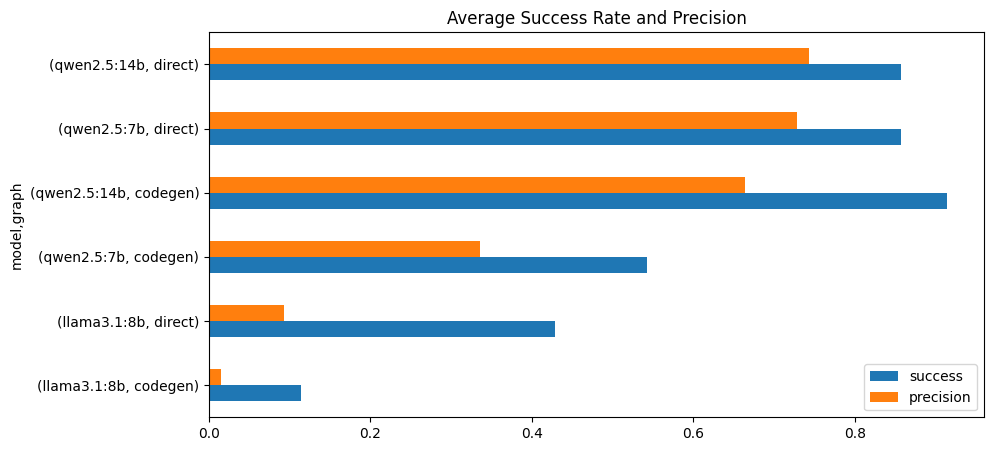

success           precision          
                         mean       std      mean       std
model       graph                                          
llama3.1:8b codegen  0.114286  0.319300  0.014286  0.119092
            direct   0.428571  0.496649  0.092857  0.291274
qwen2.5:14b codegen  0.914286  0.280947  0.664286  0.473935
            direct   0.857143  0.351184  0.742857  0.438628
qwen2.5:7b  codegen  0.542857  0.499949  0.335714  0.473935
            direct   0.857143  0.351184  0.728571  0.446293

In [168]:
fig, ax = plt.subplots(figsize=(10, 5))
# err = df.groupby(["model", "graph"]).agg({"equal": "std", "success": "std"})
_df = (
    df.groupby(["model", "graph"])
    .agg({"success": ["mean", "std"], "equal": ["mean", "std"]})
    .rename({"equal": "precision"}, axis=1)
    # .plot(kind='barh', ax=ax, ylim=(0, 1), yerr="std", title="Average Success Rate and Precision")
)
(
    _df.xs("mean", axis=1, level=1)
    .sort_values("precision")
    .plot(
        kind='barh', ax=ax, ylim=(0, 1), 
        title="Average Success Rate and Precision",
        # xerr=_df.xs("std", axis=1, level=1),
    )
)
plt.show()
_df

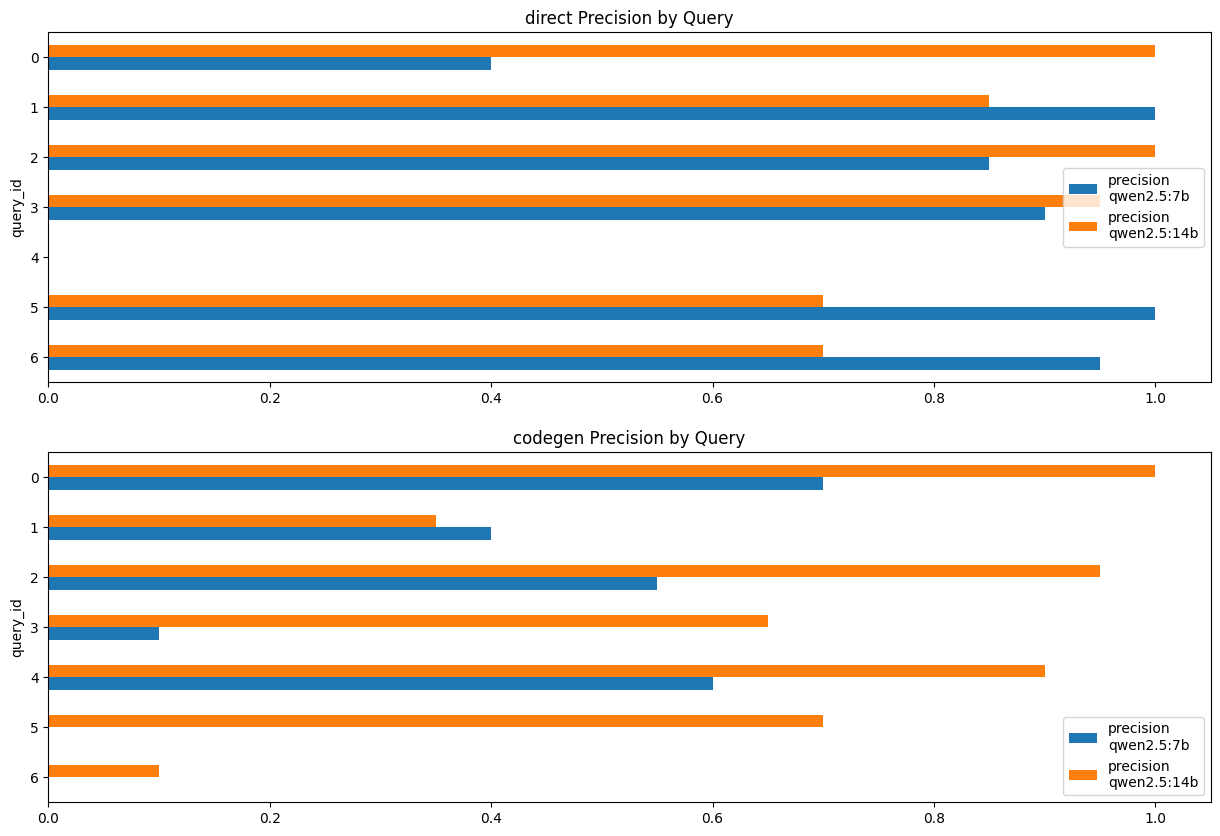

In [170]:
_mdls = [
    models.QWEN_25_7B,
    models.QWEN_25_14B,
]
fig, ax = plt.subplots(nrows=len(_mdls), figsize=(15, 10))
for i, g in enumerate(df['graph'].unique()):
    _total = pd.DataFrame()
    for _, _mdl in enumerate(_mdls):
        _df = (
            df[(df['graph'] == g) & (df['model'] == _mdl)]
            .groupby(["query_id"])
            .agg({"equal": "mean"})
            .rename({"equal": f"precision\n{_mdl}"}, axis=1)
        )
        _total = pd.concat([_total, _df], axis=1)
    (
        _total
        .sort_values("query_id", ascending=False)
        .plot(
            kind='barh', ax=ax[i], ylim=(0, 1),
            title=f"{g} Precision by Query",
        )
    )
plt.show()
# _total

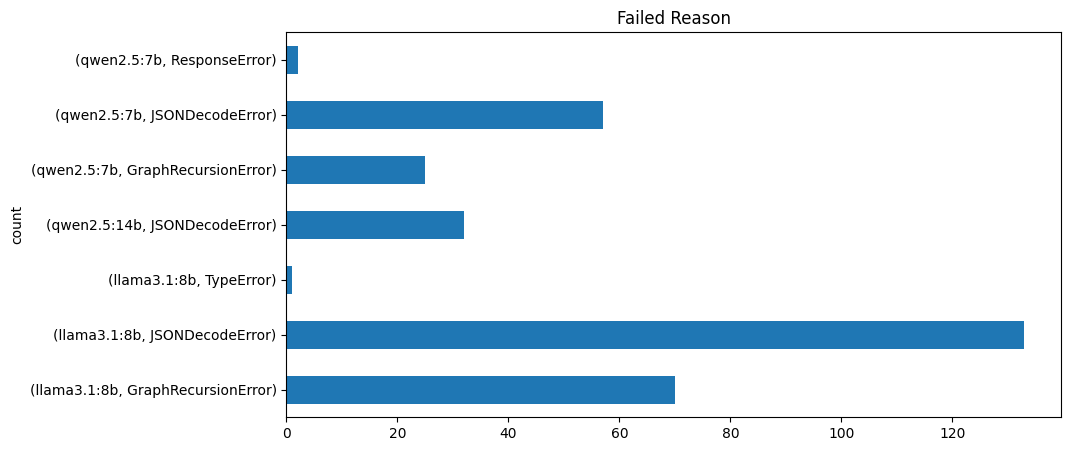

In [105]:
fig, ax = plt.subplots(figsize=(10, 5))

(
    df[df['success'] == False]
    .groupby(["model", "failed_reason"])
    .count()['query_id']
    .plot(kind='barh', ylabel="count", ax=ax, title="Failed Reason")
)
plt.show()